Best Ridge Alpha: 1.0
Best Lasso Alpha: 10.0
Model Evaluation Results:

                       R2           MSE       RMSE    CV_RMSE
Linear Regression  0.7921  2.139394e+11  462535.83  322730.32
Ridge Regression   0.8638  1.401311e+11  374340.88  355873.35
Lasso Regression   0.7930  2.129975e+11  461516.56  328850.06


C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.391e+09, tolerance: 1.776e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.403e+09, tolerance: 1.776e+09
  model = cd_fast.enet_coordinate_descent(


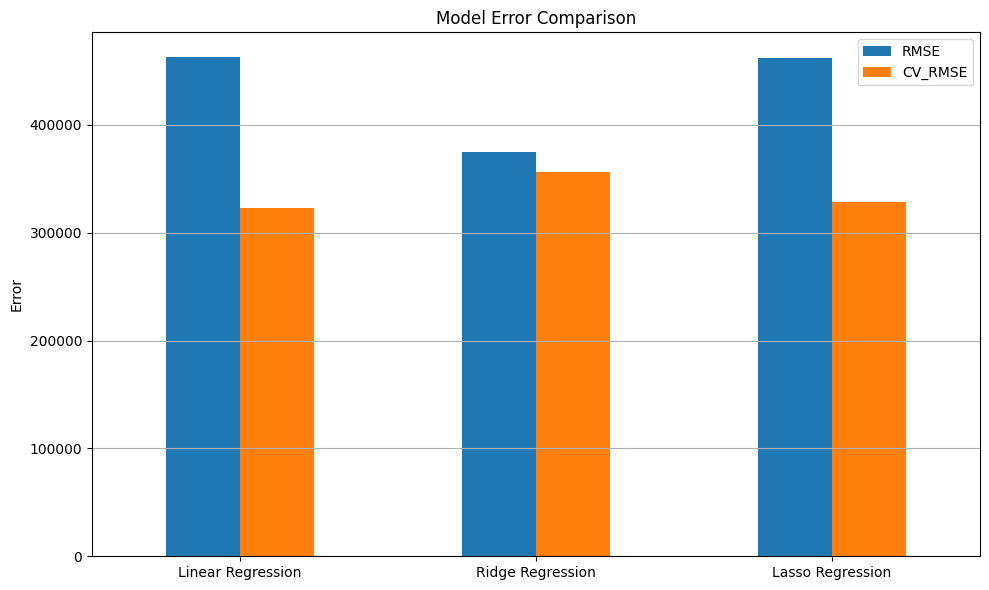

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load the dataset from your local machine
df = pd.read_csv(r"C:\Users\DELL\Downloads\housing_prices.csv")

# Display first few rows of the dataset to understand the structure
df.head()

# Separate numeric columns and categorical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Handling missing values for numeric columns (if any)
imputer = SimpleImputer(strategy='mean')  # Use mean strategy for numerical features
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# One-hot encoding for categorical features like 'City'
df = pd.get_dummies(df, columns=["City"], drop_first=True)

# Defining the feature matrix and target variable
X = df.drop("Price", axis=1)  # Assuming 'Price' is the target column
y = df["Price"]

# Feature selection (optional) - Remove features with low correlation to target
correlation_matrix = df.corr()
low_corr_features = correlation_matrix['Price'][abs(correlation_matrix['Price']) < 0.1].index
X = X.drop(columns=low_corr_features)

# Scaling features to ensure convergence for Lasso and Ridge
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models with increased max_iter for better convergence
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(max_iter=10000),  # Increased max_iter for better convergence
    'Lasso Regression': Lasso(max_iter=10000)   # Increased max_iter for better convergence
}

# Hyperparameter tuning for Ridge and Lasso using GridSearchCV
ridge_params = {'alpha': [1.0, 10.0, 100.0]}  # Adjusted alpha values for better regularization
lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}  # Adjusted alpha values for better regularization

# Results dictionary to store evaluation metrics
results = {}

# Training, evaluating, and tuning models
for name, model in models.items():
    if name == 'Ridge Regression':
        grid_search = GridSearchCV(model, ridge_params, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_alpha = grid_search.best_params_['alpha']
        print(f"Best Ridge Alpha: {best_alpha}")
        model = best_model
    elif name == 'Lasso Regression':
        grid_search = GridSearchCV(model, lasso_params, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_alpha = grid_search.best_params_['alpha']
        print(f"Best Lasso Alpha: {best_alpha}")
        model = best_model

    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Cross-validation
    cv = cross_val_score(model, X_scaled, y, cv=KFold(5), scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv.mean())

    # Store results
    results[name] = {
        'R2': round(r2, 4),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'CV_RMSE': round(cv_rmse, 2)
    }

# Creating DataFrame to compare models
results_df = pd.DataFrame(results).T
print("Model Evaluation Results:\n")
print(results_df)

# Visualizing RMSE and CV_RMSE to compare model performance
results_df[['RMSE', 'CV_RMSE']].plot(kind='bar', figsize=(10, 6), title='Model Error Comparison')
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
